In [15]:
import math
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

In [16]:
train = pd.read_csv('edit_train.csv')
test = pd.read_csv('edit_test.csv')
cluster_df = train.iloc[:, :3].drop('date_time', axis=1)

In [17]:
def cluster_evaluate(cluster_df, n_cluster, dic):

    scaler = StandardScaler()
    result = scaler.fit_transform(cluster_df)
    data_scaled = pd.DataFrame(result)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(data_scaled)
    df = pd.DataFrame(result, columns=["x", "y"])
    
    scaler = StandardScaler()
    result = scaler.fit_transform(df)
#     df = pd.DataFrame(result, columns=["x", "y"])
    
    markers = ['o', 's', '^', 'P']
    fig, axs = plt.subplots(figsize=(15,4), ncols=4)

    for ax, i in enumerate(n_cluster):
        df = pd.DataFrame(result, columns=["x", "y"])
        
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans.fit(result)
        pred_cluster = kmeans.predict(result)
        df['cluster_label'] = pred_cluster

        score_samples = silhouette_samples(result, df['cluster_label'])
        df['silhouette_coeff'] = score_samples

        mean_score = silhouette_score(result, df['cluster_label'])

        # print('===== n_cluster:{0} ====='.format(i))
        # print(df.groupby('cluster_label')['silhouette_coeff'].mean())
        # print('mean_score:{0:.4f}'.format(mean_score), '\n')
        
        cluster_unique = df['cluster_label'].unique()
        axs[ax].set_title('n_cluster:{0}'.format(i))
        
        for j in cluster_unique:
            cluster_target = df[df['cluster_label'] == j]
            axs[ax].scatter(cluster_target['x'], cluster_target['y'],
                            marker=markers[ax])
        
        dic['kmeans'+str(i)] = df
        
    plt.show()
    
    return dic

In [18]:
def gmm_cluster_evaluate(cluster_df, n_cluster, dic):

    scaler = StandardScaler()
    result = scaler.fit_transform(cluster_df)
    data_scaled = pd.DataFrame(result)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(data_scaled)
    df = pd.DataFrame(result, columns=["x", "y"])
    
    scaler = StandardScaler()
    result = scaler.fit_transform(df)
#     df = pd.DataFrame(result, columns=["x", "y"])
    
    markers = ['o', 's', '^', 'P']
    fig, axs = plt.subplots(figsize=(15,4), ncols=4)
    
    for ax, i in enumerate(n_cluster):
        df = pd.DataFrame(result, columns=["x", "y"])
        
        gmm = GaussianMixture(n_components=i, random_state=0)
        gmm.fit(result)
        pred_cluster = gmm.predict(result)
        df['cluster_label'] = pred_cluster

        score_samples = silhouette_samples(result, df['cluster_label'])
        df['silhouette_coeff'] = score_samples

        mean_score = silhouette_score(result, df['cluster_label'])

        # print('===== n_cluster:{0} ====='.format(i))
        # print(df.groupby('cluster_label')['silhouette_coeff'].mean())
        # print('mean_score:{0:.4f}'.format(mean_score), '\n')

        cluster_unique = df['cluster_label'].unique()
        axs[ax].set_title('n_cluster:{0}'.format(i))
        
        for j in cluster_unique:
            cluster_target = df[df['cluster_label'] == j]
            axs[ax].scatter(cluster_target['x'], cluster_target['y'],
                            marker=markers[ax])
        
        dic['gmm'+str(i)] = df
        
    plt.show()
    
    return dic

In [19]:
hour_cluster = pd.DataFrame(np.array(train.groupby(['date_time']).mean().iloc[:,1]).reshape(-1, 24).T)
num_cluster = pd.DataFrame(np.array(cluster_df.iloc[:, 1]).reshape(-1, 1872), index=range(1, 61))

knn_n_cluster = [4, 5, 6, 7]
gmm_n_cluster = [4, 5, 6, 7]

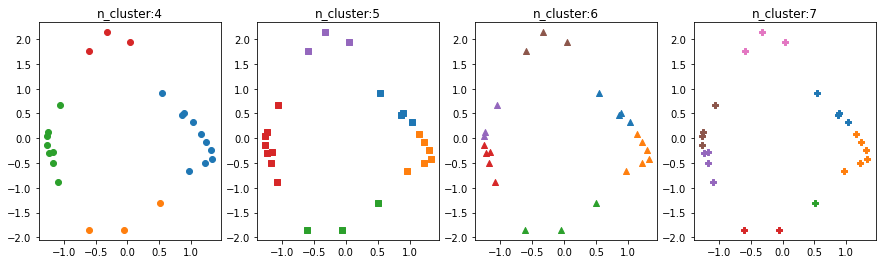

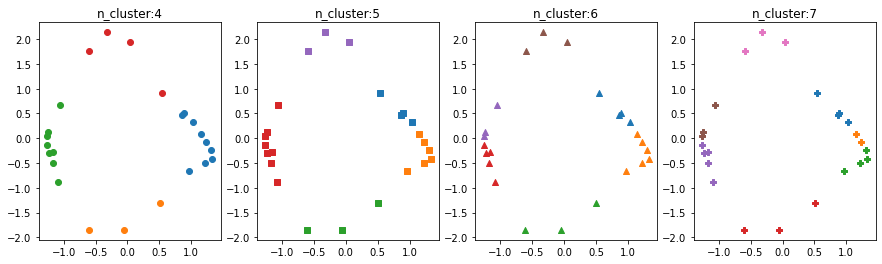

In [20]:
hour_dic = {}
hour_dic = cluster_evaluate(hour_cluster, knn_n_cluster, hour_dic)
hour_dic = gmm_cluster_evaluate(hour_cluster, gmm_n_cluster, hour_dic)

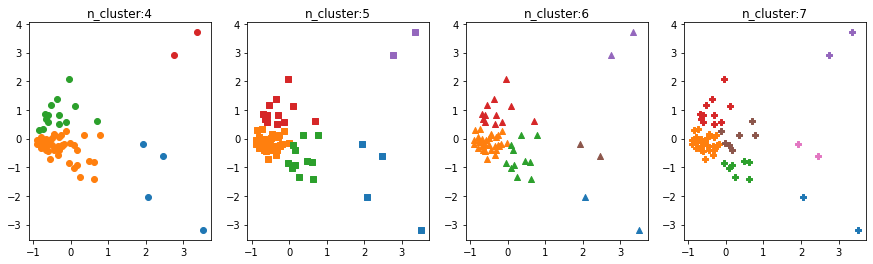

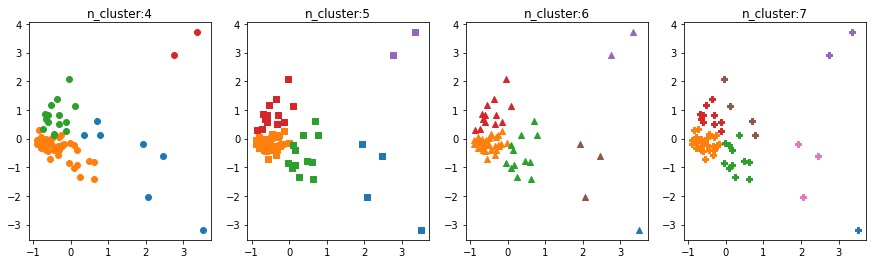

In [21]:
num_dic = {}

num_dic = cluster_evaluate(num_cluster, knn_n_cluster, num_dic)
num_dic = gmm_cluster_evaluate(num_cluster, gmm_n_cluster, num_dic)

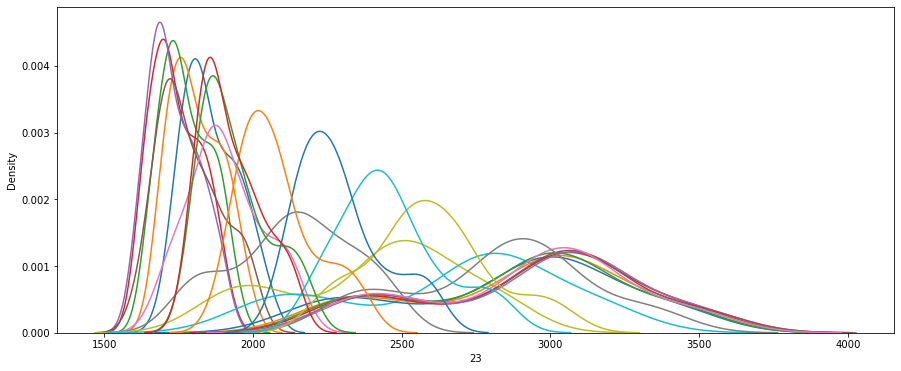

In [22]:
plt.figure(figsize=(15, 6))
for i in hour_cluster.index:
    sns.distplot(hour_cluster.iloc[i, :], hist=False)
plt.show()

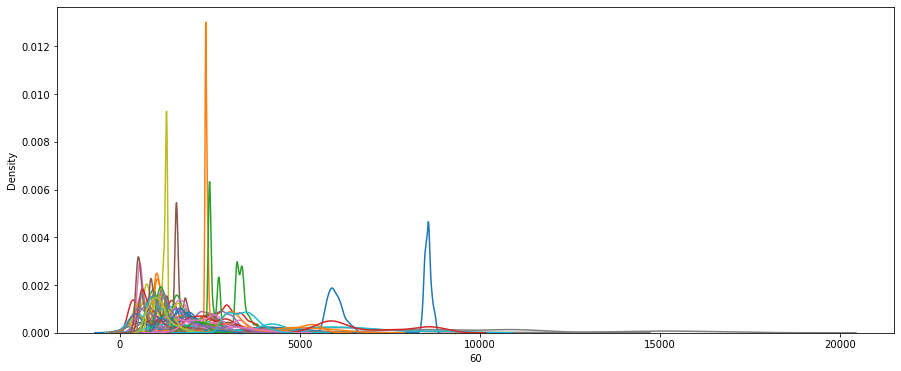

In [23]:
plt.figure(figsize=(15, 6))
for i in num_cluster.index:
    sns.distplot(num_cluster.loc[i, :], hist=False)
plt.show()

In [24]:
best_hour_cluster = hour_dic['kmeans4']
best_num_cluster = num_dic['gmm6']

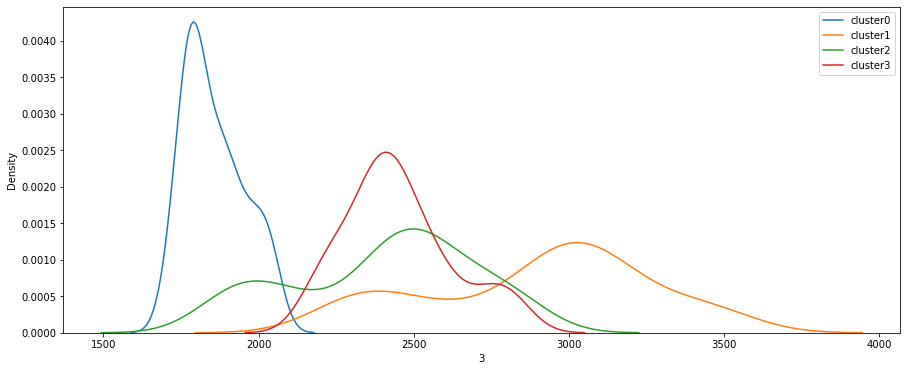

In [25]:
c = best_hour_cluster['cluster_label']
hour_cluster['cluster'] = c
hour_group_cluster = hour_cluster.groupby('cluster').mean()

plt.figure(figsize=(15, 6))
for i in hour_group_cluster.index:
    sns.distplot(hour_group_cluster.loc[i, :], hist=False, label='cluster'+str(i))
plt.legend()
plt.show()

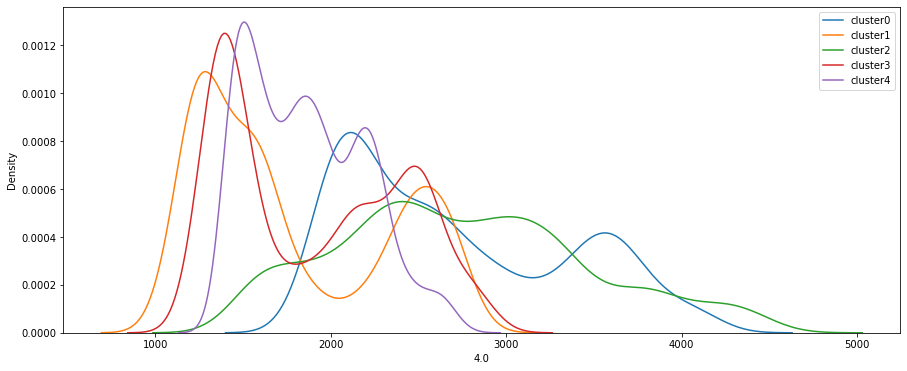

In [26]:
c = best_num_cluster['cluster_label']
num_cluster['cluster'] = c
num_group_cluster = num_cluster.groupby('cluster').mean()

plt.figure(figsize=(15, 6))
for i in num_group_cluster.index:
    sns.distplot(num_group_cluster.loc[i, :], hist=False, label='cluster'+str(int(i)))
plt.legend()
plt.show()

In [27]:
#3_1 (4, 6)

def cluster(train, test, cluster_df):
    hour_df = pd.DataFrame(train.hour.unique(), columns=['hour'])
    num_df = pd.DataFrame(train.num.unique(), columns=['num'])
    # num_hour_df = pd.DataFrame(train.num.unique(), columns=['num'])

    #feature = time, 시간별 insert

    hour_cluster = pd.DataFrame(np.array(train.groupby(['date_time']).mean().iloc[:,1]).reshape(-1, 24).T)

    scaler = StandardScaler()
    result = scaler.fit_transform(hour_cluster)
    hour_cluster = pd.DataFrame(result)

    kmeans = KMeans(n_clusters=6, init='k-means++', random_state=0)
    kmeans.fit(hour_cluster)
    clusters = kmeans.predict(hour_cluster)

    hour_df['hour_assignment'] = clusters
    train = train.merge(hour_df, how='left', on='hour')
    test = test.merge(hour_df, how='left', on='hour')


    #GMM, feature = num, 건물별 insert

    num_cluster = pd.DataFrame(np.array(cluster_df.iloc[:, 1]).reshape(-1, 1872), index=range(1, 61))

    gmm = GaussianMixture(n_components=20, random_state=0)
    gmm.fit(num_cluster)
    clusters = gmm.predict(num_cluster)

    num_df['gmm_num_assignment'] = clusters
    train = train.merge(num_df, how='left', on='num')
    test = test.merge(num_df, how='left', on='num')

    return train, test

In [28]:
train, test = cluster(train, test, cluster_df)

In [29]:
train.to_csv('edit_train.csv', index=False)
test.to_csv('edit_test.csv', index=False)

In [44]:
# hour_df = pd.DataFrame(train.hour.unique(), columns=['hour'])
# num_df = pd.DataFrame(train.num.unique(), columns=['num'])
# num_hour_df = pd.DataFrame(train.num.unique(), columns=['num'])

In [163]:
# #feature = time, 시간별 insert

# hour_cluster = pd.DataFrame(np.array(train.groupby(['date_time']).mean().iloc[:,1]).reshape(-1, 24).T)

# scaler = StandardScaler()
# result = scaler.fit_transform(hour_cluster)
# hour_cluster = pd.DataFrame(result)

# kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
# kmeans.fit(hour_cluster)
# clusters = kmeans.predict(hour_cluster)

# hour_df['hour_assignment'] = clusters
# train = train.merge(hour_df, how='left', on='hour')
# test = test.merge(hour_df, how='left', on='hour')

# #feature = num, 건물별 insert

# num_cluster = pd.DataFrame(np.array(cluster_df.iloc[:, 1]).reshape(-1, 2040), index=range(1, 61))

# scaler = StandardScaler()
# result = scaler.fit_transform(num_cluster)
# num_cluster = pd.DataFrame(result)

# kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0)
# kmeans.fit(num_cluster)
# clusters = kmeans.predict(num_cluster)

# num_df['num_assignment'] = clusters
# train = train.merge(num_df, how='left', on='num')
# test = test.merge(num_df, how='left', on='num')

In [165]:
# hour_df = pd.DataFrame(train.hour.unique(), columns=['hour'])
# num_df = pd.DataFrame(train.num.unique(), columns=['num'])
# num_hour_df = pd.DataFrame(train.num.unique(), columns=['num'])

In [166]:
# #GMM, feature = time, 시간별 insert

# hour_cluster = pd.DataFrame(np.array(train.groupby(['date_time']).mean().iloc[:,1]).reshape(-1, 24).T)

# gmm = GaussianMixture(n_components=5, random_state=0)
# gmm.fit(hour_cluster)
# clusters = gmm.predict(hour_cluster)

# hour_df['gmm_hour_assignment'] = clusters
# train = train.merge(hour_df, how='left', on='hour')
# test = test.merge(hour_df, how='left', on='hour')

# #GMM, feature = num, 건물별 insert

# num_cluster = pd.DataFrame(np.array(cluster_df.iloc[:, 1]).reshape(-1, 2040), index=range(1, 61))

# gmm = GaussianMixture(n_components=10, random_state=0)
# gmm.fit(num_cluster)
# clusters = gmm.predict(num_cluster)

# num_df['gmm_num_assignment'] = clusters
# train = train.merge(num_df, how='left', on='num')
# test = test.merge(num_df, how='left', on='num')